# Load thư viện

In [124]:
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp

import numpy as np 
import pandas as pd

from matplotlib import pyplot

from pandas import DataFrame
from pandas import Grouper

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot

from statsmodels.tsa.arima_model import ARIMAResults

# Load Data

In [125]:
from google.colab import drive
drive.mount('/content/gdrive')

ts = pd.read_csv("/content/gdrive/MyDrive/DoAn_TimeSeries/Robberies.csv",header=0, index_col=0, parse_dates=True, squeeze=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [126]:
ts 

Months
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1975-06-01    316
1975-07-01    398
1975-08-01    394
1975-09-01    431
1975-10-01    431
Name: Robberies, Length: 118, dtype: int64

# Split Train/Validation

In [127]:
split_point = len(ts) - 12
dataset, validation = ts[0:split_point], ts[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 106, Validation 12


# Chuẩn bị dữ liệu

In [128]:
X = ts.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# Đánh giá một mô hình Persistence

# Walk-forward validation(Kiểm tra tiến bộ)


In [129]:
# Kiểm tra tiến bộ
history = [x for x in train]
predict = list()

for i in range(len(test)):
    # Dự đoán
    yhat = history[-1]
    predict.append(yhat)
    # quan sát
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

##báo cáo hiệu suất
#rmse = sqrt(mean_squared_error(test,predict))
#print('RMSE: %.3f' % rmse)

>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>Predicted=339.000, Expected=308.000
>Predicted=308.000, Expected=247.000
>Predicted=247.000, Expected=257.000
>Predicted=257.000, Expected=322.000
>Predicted=322.000, Expected=298.000
>Predicted=298.000, Expected=273.000
>

## Report Performance(Báo cáo hiệu suất)

In [130]:
rmse = sqrt(mean_squared_error(test, predict)) 
print('RMSE: %.3f' % rmse)

RMSE: 54.191


#Summary Statistics(Thống kê tóm tắt)

In [131]:
print(ts.describe())

count    118.000000
mean     196.288136
std      128.043602
min       29.000000
25%       85.500000
50%      166.000000
75%      296.750000
max      500.000000
Name: Robberies, dtype: float64


#Line Plot 

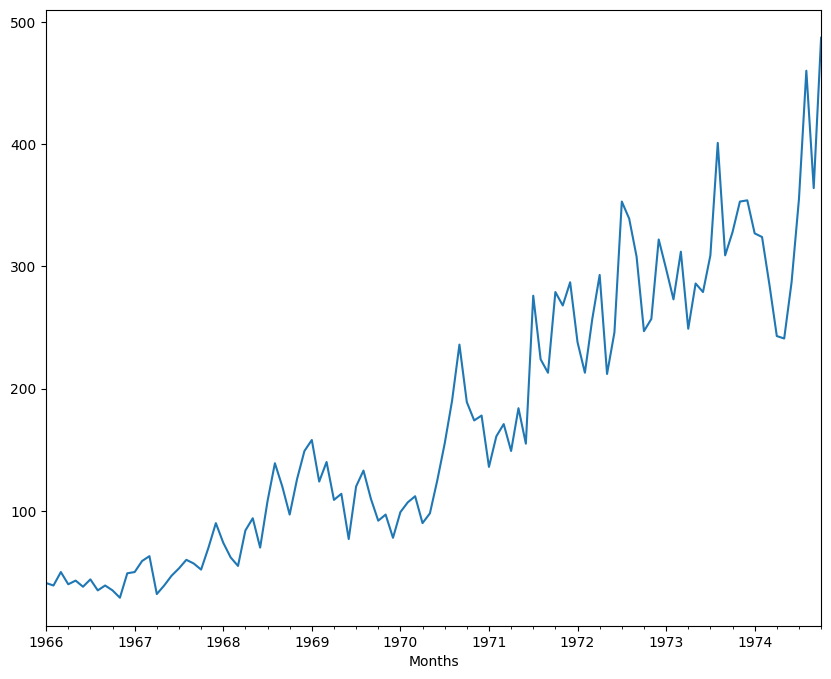

In [132]:
series = dataset
pyplot.figure(figsize=(10,8))
series.plot()
pyplot.show()

# Density Plot

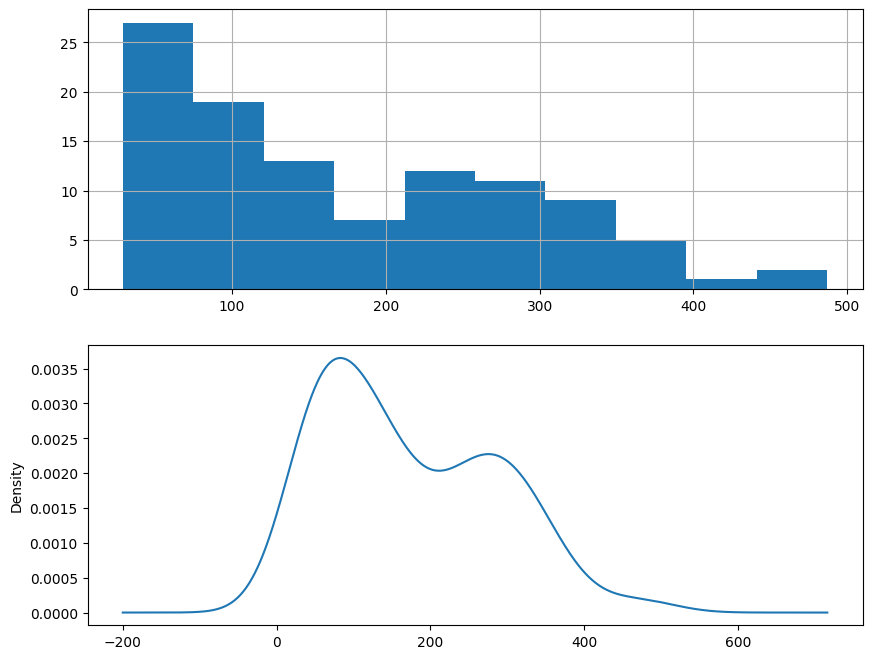

In [133]:
pyplot.figure(1, figsize=(10,8))
pyplot.subplot(211)
series.hist()

pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

# Box and Whisker Plots

Months
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1974-06-01    287
1974-07-01    355
1974-08-01    460
1974-09-01    364
1974-10-01    487
Name: Robberies, Length: 106, dtype: int64


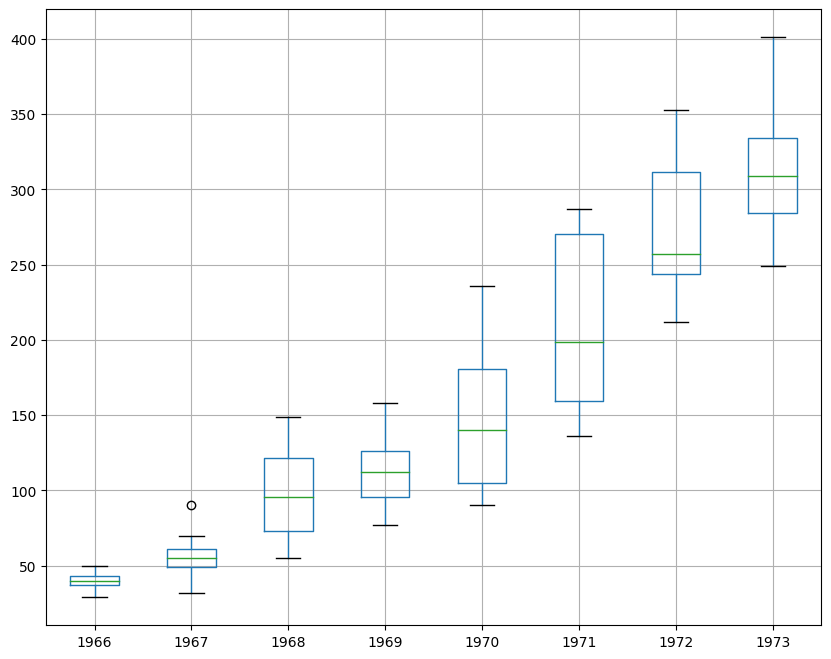

In [134]:
print(series)
groups = series['1966':'1973'].groupby(Grouper(freq='A')) 
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
pyplot.figure(figsize=(10,8))
years.boxplot()
pyplot.show()

# ARIMA Model

# Manually Configured ARIMA(Cấu hình ARIMA thủ công)

# Create a differenced time series(Tạo một chuỗi thời gian sai phân)

In [135]:
#tạo ra một chuỗi thời gian khác biệt
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pd.Series(diff)

In [136]:
#kiểm tra thống kê cho tính dừng của chuỗi thời gian
series = dataset

X = series.values

# difference data
stationary = difference(X)
stationary.index = series.index[1:]

# kiểm tra xem có đứng yên không
result = adfuller(stationary) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value)) # save

#Lưu
stationary.to_csv('stationary.csv')

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


# ACF and PACF plots of time series(Biểu đồ ACF và PACF của chuỗi thời gian)

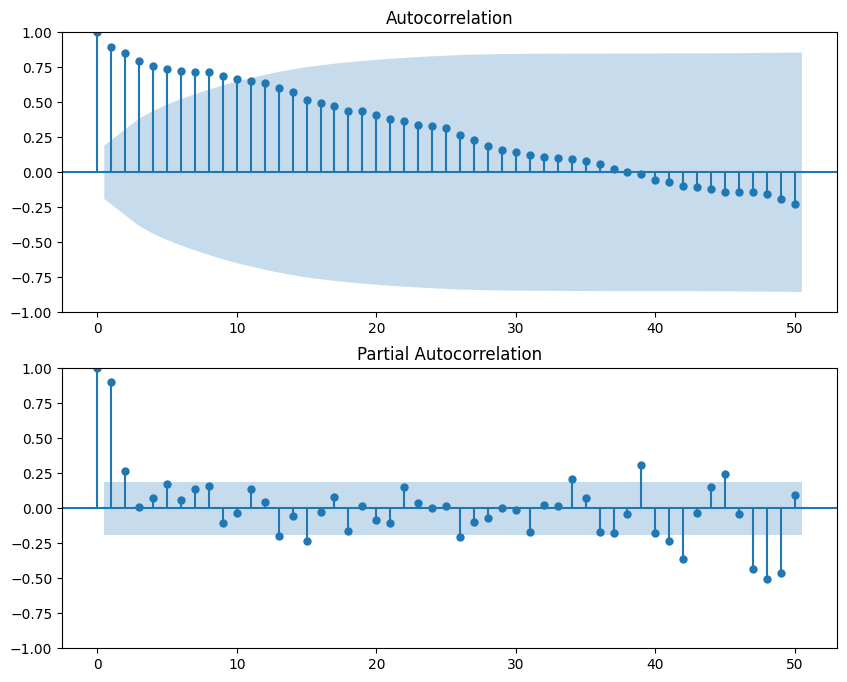

In [137]:
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) pyplot.figure()

series = dataset
pyplot.figure(figsize=(10,8))
pyplot.subplot(211)
plot_acf(series, lags=50, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=50, ax=pyplot.gca())
pyplot.show()

# Evaluate manually configured ARIMA model(Đánh giá mô hình ARIMA cấu hình thủ công)

In [138]:
# load data
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # prepare data

from statsmodels.tsa.arima.model import ARIMA

X = ts.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# xác thực chuyển tiếp
history = [x for x in train]
predict = list()

for i in range(len(test)):
    # Dự báo
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predict.append(yhat)
    # quan sát
    obs = test[i]
    history.append(obs)
    print('>Dự đoán=%.3f, Dự kiến=%.3f' % (yhat, obs))

>Dự đoán=180.705, Dự kiến=178.000
>Dự đoán=179.873, Dự kiến=136.000
>Dự đoán=141.098, Dự kiến=161.000
>Dự đoán=166.173, Dự kiến=171.000
>Dự đoán=167.005, Dự kiến=149.000
>Dự đoán=150.656, Dự kiến=184.000
>Dự đoán=182.314, Dự kiến=155.000
>Dự đoán=154.213, Dự kiến=276.000
>Dự đoán=245.214, Dự kiến=224.000
>Dự đoán=225.902, Dự kiến=213.000
>Dự đoán=216.867, Dự kiến=279.000
>Dự đoán=258.698, Dự kiến=268.000
>Dự đoán=263.377, Dự kiến=287.000
>Dự đoán=279.945, Dự kiến=238.000
>Dự đoán=251.485, Dự kiến=213.000
>Dự đoán=226.574, Dự kiến=257.000
>Dự đoán=249.690, Dự kiến=293.000
>Dự đoán=277.211, Dự kiến=212.000
>Dự đoán=230.020, Dự kiến=246.000
>Dự đoán=245.786, Dự kiến=353.000
>Dự đoán=317.992, Dự kiến=339.000
>Dự đoán=313.734, Dự kiến=308.000
>Dự đoán=305.556, Dự kiến=247.000
>Dự đoán=263.416, Dự kiến=257.000
>Dự đoán=272.428, Dự kiến=322.000
>Dự đoán=310.225, Dự kiến=298.000
>Dự đoán=288.644, Dự kiến=273.000
>Dự đoán=280.371, Dự kiến=312.000
>Dự đoán=307.468, Dự kiến=249.000
>Dự đoán=258.4

## Report Performance(Báo cáo hiệu suất)

In [139]:
rmse = sqrt(mean_squared_error(test, predict))
print('RMSE: %.3f' % rmse)

RMSE: 52.494


# Grid Search ARIMA Hyperparameters(Tìm kiếm lưới các tham số siêu ARIMA)

## Evaluate an ARIMA model for a given order (p,d,q) and return RMSE(Đánh giá một mô hình ARIMA cho một thứ tự cho trước (p,d,q) và trả về RMSE)


In [140]:
def evaluate_arima_model(X, arima_order): # chuẩn bị tập dữ liệu huấn luyện
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Dự đoán
    predict = list()
    
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predict.append(yhat)
        history.append(test[t])
    
    # tính toán lỗi mẫu
    rmse = sqrt(mean_squared_error(test, predict))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model(Đánh giá các tổ hợp giá trị p, d và q cho một mô hình ARIMA)

In [141]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype("float32")
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print("ARIMA%s RMSE=%.3f" % (order, rmse))
                except:
                    continue
    print("Best ARIMA%s RMSE=%.3f" % (best_cfg, best_score))

# Evaluate(Đánh giá)

In [142]:
%%time
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # evaluate parameters
series = dataset
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
#evaluate_models(series.values, p_values, d_values, q_values)

CPU times: user 29 µs, sys: 14 µs, total: 43 µs
Wall time: 47.9 µs


# Review Residual Errors(Xem xét các sai số dư)

In [143]:
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # prepare data
series = dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)

# Plot Residuals

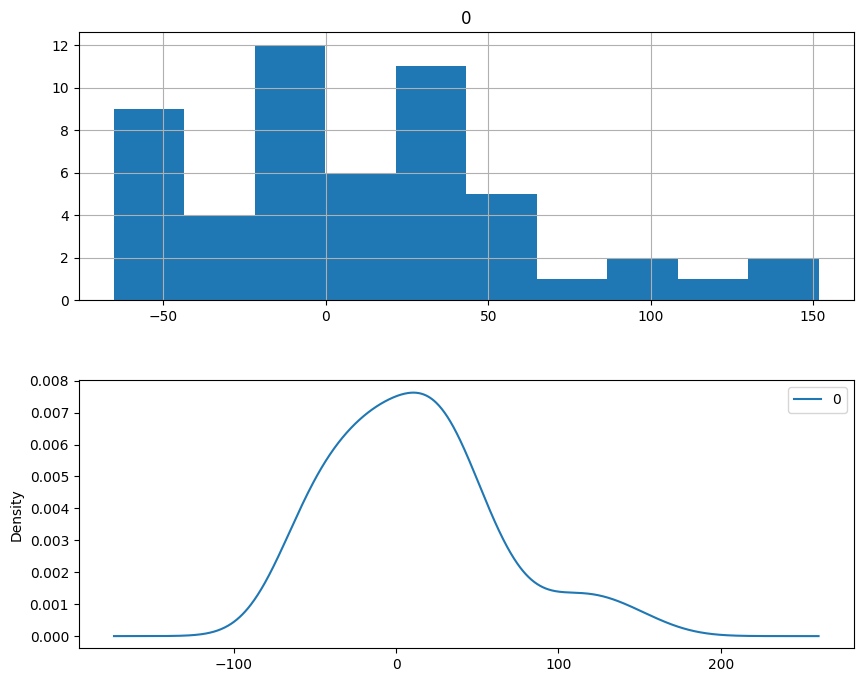

In [144]:
pyplot.figure(figsize=(10,8))
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

# ACF and PACF plots of forecast residual errors(Sơ đồ ACF và PACF của sai số dư dự báo)

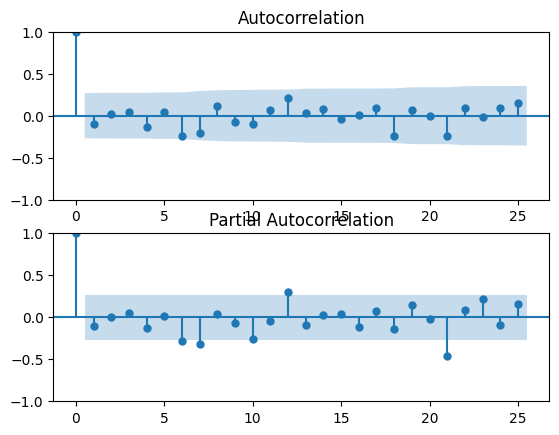

In [145]:

series = dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# Kiểm tra tiến bộ
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)

    # observation
    obs = test[i]
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

# Box-Cox Transformed Dataset(Tập dữ liệu được biến đổi Box-Cox)

Lambda: 0.259926


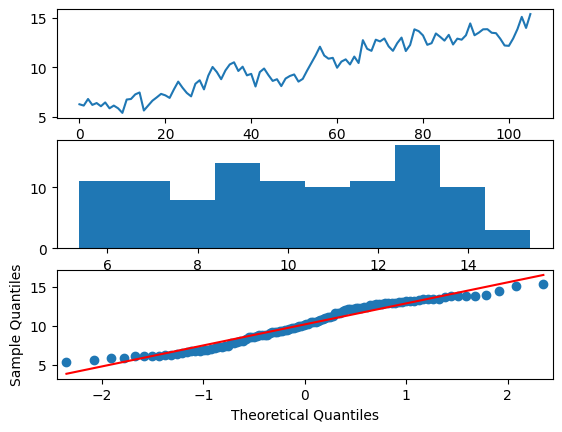

In [146]:
series = dataset
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)


#Line Plot
pyplot.subplot(311)
pyplot.plot(transformed)

#Histogram Plot
pyplot.subplot(312)
pyplot.hist(transformed)

#q-q Plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

# Invert Box-Cox transform(Đảo ngược phép biến đổi Box-Cox))

In [147]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)    

In [148]:
series = dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)

train, test = X[0:train_size], X[train_size:]

# Kiểm tra tiến bộ
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # biến đổi
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1

    # dự đoán
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]

    # đảo ngược dự đoán biến đổi
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # quan sát
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))


>Predicted=99.650, Expected=125.000
>Predicted=115.208, Expected=155.000
>Predicted=136.148, Expected=190.000
>Predicted=165.522, Expected=236.000
>Predicted=206.453, Expected=189.000
>Predicted=180.934, Expected=174.000
>Predicted=178.196, Expected=178.000
>Predicted=179.316, Expected=136.000
>Predicted=145.460, Expected=161.000
>Predicted=165.568, Expected=171.000
>Predicted=166.484, Expected=149.000
>Predicted=152.065, Expected=184.000
>Predicted=179.561, Expected=155.000
>Predicted=155.211, Expected=276.000
>Predicted=238.977, Expected=224.000
>Predicted=210.753, Expected=213.000
>Predicted=214.075, Expected=279.000
>Predicted=257.447, Expected=268.000
>Predicted=255.413, Expected=287.000
>Predicted=275.941, Expected=238.000
>Predicted=245.090, Expected=213.000
>Predicted=226.699, Expected=257.000
>Predicted=252.344, Expected=293.000
>Predicted=275.302, Expected=212.000
>Predicted=224.656, Expected=246.000
>Predicted=248.227, Expected=353.000
>Predicted=313.577, Expected=339.000
>P

## Report Performance(Báo cáo hiệu suất)

In [149]:
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 50.223


# Model Validation(Xác thực mô hình)

## Finalize Model(Hoàn thiện mô hình)

In [150]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_ar, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
series = dataset
# prepare data

X = series.values
X = X.astype('float32')


# transform data
transformed, lam = boxcox(X)

# Fit Model(Huấn luyện mô hình)

In [151]:
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit()

# Save Model(Lưu mô hình)

In [152]:
model_fit.save('model.pkl') 
np.save('model_lambda.npy', [lam])

# Make Prediction(Dự đoán)

In [153]:
import pickle
from statsmodels.tsa.arima.model import ARIMA

# Tải mô hình từ tập tin
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Tải tham số lambda
lam = np.load('model_lambda.npy')

# Đưa ra dự báo
yhat = model.forecast()[0]

# Đảo ngược biến đổi Box-Cox
if lam == 0:
    yhat = np.exp(yhat)
else:
    yhat = np.exp(np.log(lam*yhat + 1)/lam)

print('Predicted: %.3f' % yhat)


Predicted: 452.365


# Evaluate the finalized model on the validation dataset(Đánh giá mô hình hoàn thiện trên tập dữ liệu xác thực)

In [154]:
# đảo ngược biến đổi box-cox
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)
X = dataset.values.astype('float32')
history = [x for x in X]
y = validation.values.astype('float32')
# Tải mô hình
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
# Tải tham số lambda
lam = np.load('model_lambda.npy')
# đưa ra dự đoán đầu tiên
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0])) 
# Dự báo
for i in range(1, len(y)):
    # Biến đổi
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # dự báo
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # đảo ngược dự đoán biến đổi
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # quan sát
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs)) 

>Predicted=452.365, Expected=452.000
>Predicted=429.900, Expected=391.000
>Predicted=401.393, Expected=500.000
>Predicted=476.461, Expected=451.000
>Predicted=442.454, Expected=375.000
>Predicted=397.527, Expected=372.000
>Predicted=390.647, Expected=302.000
>Predicted=329.393, Expected=316.000
>Predicted=334.171, Expected=398.000
>Predicted=382.819, Expected=394.000
>Predicted=378.508, Expected=431.000
>Predicted=413.525, Expected=431.000


## Report Performance(Báo cáo hiệu suất)

RMSE: 51.949


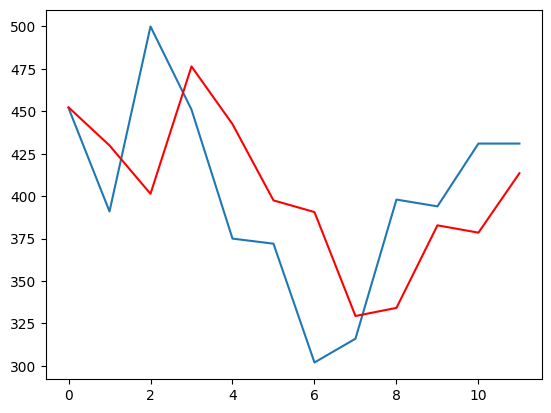

In [158]:
rmse = sqrt(mean_squared_error(y, predictions)) 
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()